# Libraries and Modules import

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os 
import collections
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import glob
import streamlit as st
from traitlets.config import Config
from itertools import compress

st.set_option('deprecation.showPyplotGlobalUse', False)
pd.options.mode.chained_assignment = None

dir = 'Data Mining Assignment Dataset'

print("Ready to use ! ")

Ready to use ! 


In [81]:
QuestionSB = st.sidebar.selectbox("Questions", ["Question 1(Missing Value)", "Question 1(EDA)", "Question 2", "Question 3", "Question 4"], key="QuestionSB")

# General Functions

# List of Dataframe and States

In [3]:
file_list = glob.glob(dir+"/*." +"csv")
print(file_list)

df = {}
for i, names in enumerate(file_list):
    df[file_list[i].replace(dir+"\\", '').replace(".csv",'')] = pd.read_csv(file_list[i])

print(df['deaths_state'].head())

# Get the array list for States in Malaysia
state_list = list(np.unique(df['deaths_state']['state']))
print(state_list)

['Data Mining Assignment Dataset\\cases_malaysia.csv', 'Data Mining Assignment Dataset\\cases_state.csv', 'Data Mining Assignment Dataset\\clusters.csv', 'Data Mining Assignment Dataset\\deaths_malaysia.csv', 'Data Mining Assignment Dataset\\deaths_state.csv', 'Data Mining Assignment Dataset\\hospital.csv', 'Data Mining Assignment Dataset\\icu.csv', 'Data Mining Assignment Dataset\\pkrc.csv', 'Data Mining Assignment Dataset\\population.csv']
         date            state  deaths_new
0  2020-03-17            Johor           1
1  2020-03-17            Kedah           0
2  2020-03-17         Kelantan           0
3  2020-03-17           Melaka           0
4  2020-03-17  Negeri Sembilan           0
['Johor', 'Kedah', 'Kelantan', 'Melaka', 'Negeri Sembilan', 'Pahang', 'Perak', 'Perlis', 'Pulau Pinang', 'Sabah', 'Sarawak', 'Selangor', 'Terengganu', 'W.P. Kuala Lumpur', 'W.P. Labuan', 'W.P. Putrajaya']


# Question (i) Answers


## EDA and Outliers detection

#### For EDA, I will be using pd.Dataframe.describe() function to get the summary of the dataframe, such as the number of rows, 5 number summary, etc. This will give me a better feel and understanding of the data properties.

####  Because of the nature of the data, I will be setting the outlier boundary with the formula: Q3 + 3IQR and not Q1-3IQR because the data started really low and it is impossible to get negative cases infected.

## Missing Values Detection


#### Unlike looking for outliers, which might require different detection methods depending on the nature of the data, it is always good to know all the locations of missing values in the datasets. 
#### In this part of the code, I will be looping through every row for each column in all of the datasets in this assignment. The information of data missing including the type of data, location and the number of missing values would be detected in this following codes. 

In [128]:
for key, value in df.items():
    date_columns = [column for column in value.columns if 'date'in column]
    if len(date_columns) > 0:
        for date_column in date_columns:
            df[key][date_column] = pd.to_datetime(df[key][date_column])
        
if QuestionSB == "Question 1(Missing Value)":
    st.title("Data Type Checking and Outliers Detection")
    for key, value in df.items():
        st.header("Dataframe/File Name: "+key)
        variable_dtypes_df = value.dtypes.to_frame()
        variable_dtypes_df.rename(columns={0: "dtypes"}, inplace=True)
        variable_dtypes_df["isna"] = value.isna().sum()
        st.write(variable_dtypes_df)
        print(variable_dtypes_df)

                                 dtypes  isna
date                     datetime64[ns]     0
cases_new                       float64     0
cluster_import                  float64   342
cluster_religious               float64   342
cluster_community               float64   342
cluster_highRisk                float64   342
cluster_education               float64   342
cluster_detentionCentre         float64   342
cluster_workplace               float64   342
                   dtypes  isna
date       datetime64[ns]     0
state              object     0
cases_new           int64     0
                         dtypes  isna
cluster                  object     0
state                    object     0
district                 object     0
date_announced   datetime64[ns]     0
date_last_onset  datetime64[ns]     0
category                 object     0
status                   object     0
cases_new                 int64     0
cases_total               int64     0
cases_active              int64 

In [152]:
def advanceGrouping(df,alignColumn,targetColumn):
    cases_states_df = pd.DataFrame(data={alignColumn: df[alignColumn].unique()})
    for value in df[targetColumn].unique():
        cases_state_df = df[df[targetColumn] == value]
        cases_state_df.rename(columns={'cases_new': value}, inplace=True)
        cases_state_df.drop([targetColumn], axis='columns', inplace=True)
        cases_states_df = cases_states_df.merge(cases_state_df, how='inner', on='date')
    return cases_states_df

def createBoxPlot(df,show_count_table):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.boxplot(data=df)
    if(df.shape[1] > 1):
        ax.set_xticklabels(ax.get_xticklabels(),rotation=-60, horizontalalignment='left')
    st.pyplot()

    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    IQR = Q3 - Q1
    cases_outliers_df = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum().to_frame()
    cases_outliers_df.rename(columns={0: "Count of outlier"}, inplace=True)
    if show_count_table:
        st.table(cases_outliers_df)
    return ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))

if QuestionSB == "Question 1(EDA)":
    st.title("Exploratory Data Analysis")
    state_listSB = st.selectbox("State", ["All State"]+state_list)
    
    cases_states_df = advanceGrouping(df['cases_state'],'date','state')
    if(state_listSB != "All State"):
        state = state_listSB
        
        st.header(state + "'s cases_state EDA")
        st.table(cases_states_df[state].to_frame().describe())
        
        st.header(state + "'s boxplot")
        mask = createBoxPlot(cases_states_df[state].to_frame(),False)
        
        st.header(state + "'s outlier")
        outlier_df = pd.DataFrame(list(compress(cases_states_df[state], mask[state])))
        outlier_df.rename(columns={0: "outliers"}, inplace=True)
        st.table(outlier_df)
    else:
        st.header("All state's cases_state EDA")
        st.write(cases_states_df.describe())
        
        st.header("All state's boxplot")
        createBoxPlot(cases_states_df[cases_states_df.columns.difference(['date'])],True)

    Count of outlier
0               1103
1               1069
2               1020
3               1068
4                964
5                876
6                950
7               1449
8                907
9               1054
10              1104
11              1144
12              1045
13              1222
14              1275
15              1162
16              1300
17              1275
18              1182
19              1308
20              1232
21              1344
22              1693
23              1706
24              1485
25              1425
26              1508
27              1510
28              1309
29              1477
30              1526
31              1323
32              1558
33              1391
34              1367
35              1743
36              1832
37              2785


# Question (ii) Answers

## Question: What are the states that exhibit strong correlation with Pahang and Johor

#### To search for the states that has strong correlation with Pahang and Johor, I will be using 'corr()' function from pandas.

In [86]:
# Joining the states into a single dataframe 
if QuestionSB == "Question 2":
    st.title("Correlation")
    st.header("Heat Map of case state")
    state_cases_df = advanceGrouping(df['cases_state'],'date','state')
    state_cases_correlation = state_cases_df.corr()
    sns.heatmap(state_cases_correlation, vmax=.8, square=True, annot=True, fmt='.2f', annot_kws={'size': 5}, cmap=sns.color_palette("Blues"))
    
    st.pyplot()

In [10]:
if QuestionSB == "Question 2":
    pahang_correlation = state_cases_correlation.loc[state_cases_correlation.index == 'Pahang']
    johor_correlation = state_cases_correlation.loc[state_cases_correlation.index == 'Johor']
    
    st.header("Heat Map of case state (Johor)")
    ax = johor_correlation.plot.bar(rot=0, figsize = (15,8), title = 'Correlation with Johor')
    plt.show()
    st.pyplot()
    
    st.header("Heat Map of case state (Pahang)")
    ax1 = pahang_correlation.plot.bar(rot=0, figsize = (15,8), title = 'Correlation with Pahang')
    plt.show()
    st.pyplot()

### From the correlation table, we could see that the state Pahang is strongly correlated with Kedah, Melaka, Selangor and Terrenganu. These for states posted a correlation at a rate of above 90% (0.9)

### From the correlation table, we could see that none of the states have a correlation with Johor that is abouve 90%(0.9). The state with the highest correlation with Johor is Pulau Pinang.

# Question (iii) Answers

### What are the strong features/indicators to daily cases for Pahang, Kedah, Johor and Selangor. Use at least 2 methods to justify your findings


In [125]:
# This part of the code will show error if it is runned for the second time without re-runing the whole program 

# Get all the individual state of the question from the dataframe 
q3_state_list = ['Johor', 'Pahang', 'Kedah', 'Selangor']

q3_df_title = [file.replace(dir+"\\", '').replace(".csv",'') for file in file_list]
    
q3_df_title.remove('clusters')
q3_df_title.remove('population')
q3_df_title.remove('cases_malaysia')
q3_df_title.remove('deaths_malaysia')
print(q3_df_title)


['cases_state', 'deaths_state', 'hospital', 'icu', 'pkrc']


In [12]:
q3_combined_df = {}

# Isolate individual states into seperate dataframes and combining all the data collected except for clusters.csv and population.csv and country level data
for q3_state in q3_state_list:
    i = 0
    for q3_title in q3_df_title:
        q3_df = df[q3_title]
        print('Currently Extracting ' + q3_title +' from '+ q3_state)
        q3_temp_df = q3_df[q3_df['state'] == q3_state]
        if i == 0: 
            q3_combined_df[q3_state] = q3_temp_df
        else:
            q3_combined_df[q3_state] = q3_combined_df[q3_state].merge(q3_temp_df, how='inner', on='date')
        i+=1
        
# Remove the duplicated 'state' column in the dataframes
for states in q3_state_list:
    q3_combined_df[states] = q3_combined_df[states].drop(columns=['state_x', 'state_y'])
    q3_combined_df[states]['state'] = states

q3_combined_df = q3_combined_df
print(q3_combined_df["Johor"])

Currently Extracting cases_state from Johor
Currently Extracting deaths_state from Johor
Currently Extracting hospital from Johor
Currently Extracting icu from Johor
Currently Extracting pkrc from Johor
Currently Extracting cases_state from Pahang
Currently Extracting deaths_state from Pahang
Currently Extracting hospital from Pahang
Currently Extracting icu from Pahang
Currently Extracting pkrc from Pahang
Currently Extracting cases_state from Kedah
Currently Extracting deaths_state from Kedah
Currently Extracting hospital from Kedah
Currently Extracting icu from Kedah
Currently Extracting pkrc from Kedah
Currently Extracting cases_state from Selangor
Currently Extracting deaths_state from Selangor
Currently Extracting hospital from Selangor
Currently Extracting icu from Selangor
Currently Extracting pkrc from Selangor
          date  cases_new  deaths_new  beds  beds_covid  beds_noncrit  \
0   2020-04-02         27           3  2646         474          2579   
1   2020-04-03        

C:\Users\wangl\anaconda3\lib\site-packages\pandas\core\frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'state_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
C:\Users\wangl\anaconda3\lib\site-packages\pandas\core\frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'state_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
C:\Users\wangl\anaconda3\lib\site-packages\pandas\core\frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'state_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
C:\Users\wangl\anaconda3\lib\site-packages\pandas\core\frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'state_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


------------------------------------------------------------
Currently Showing state: Johor


<Figure size 640x480 with 0 Axes>

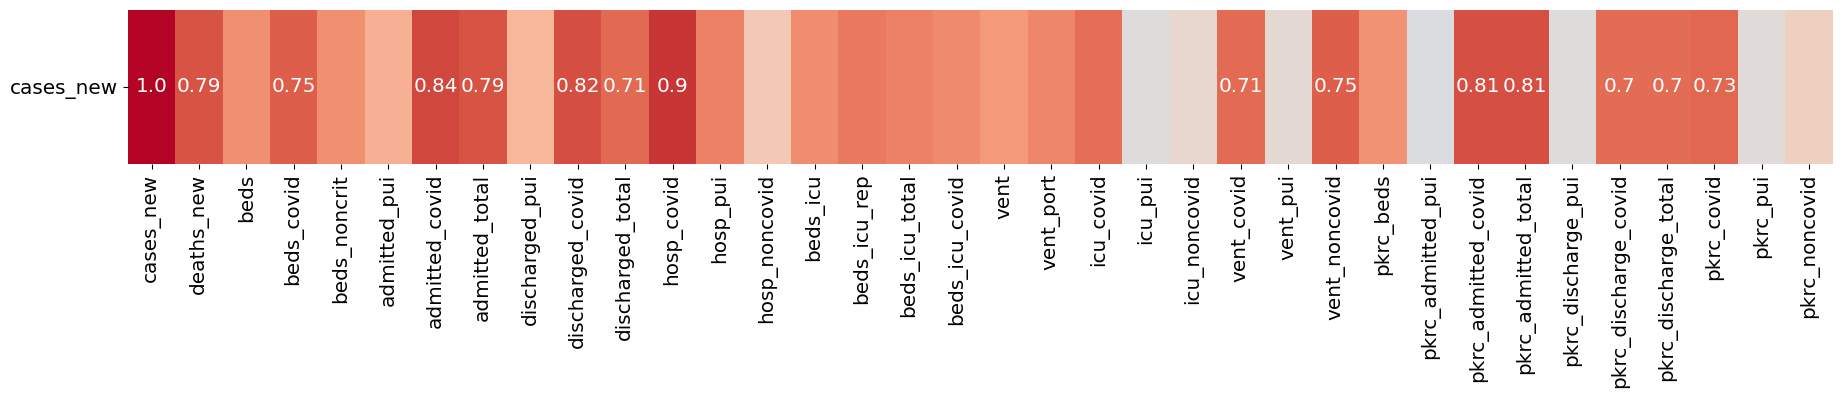

------------------------------------------------------------
Currently Showing state: Pahang


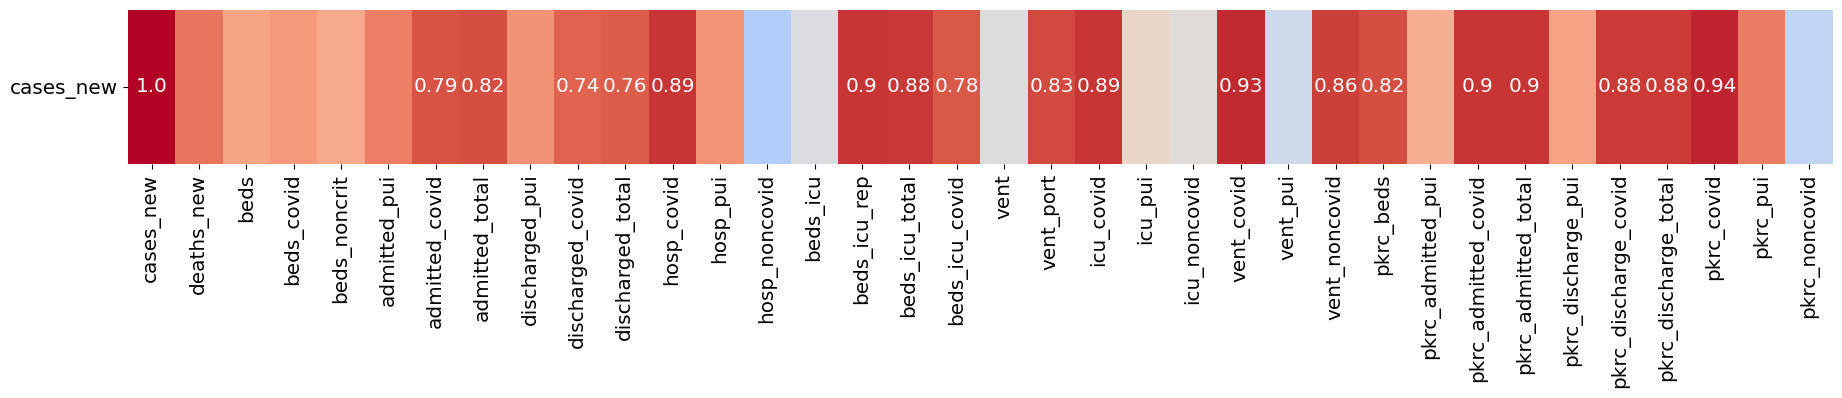

------------------------------------------------------------
Currently Showing state: Kedah


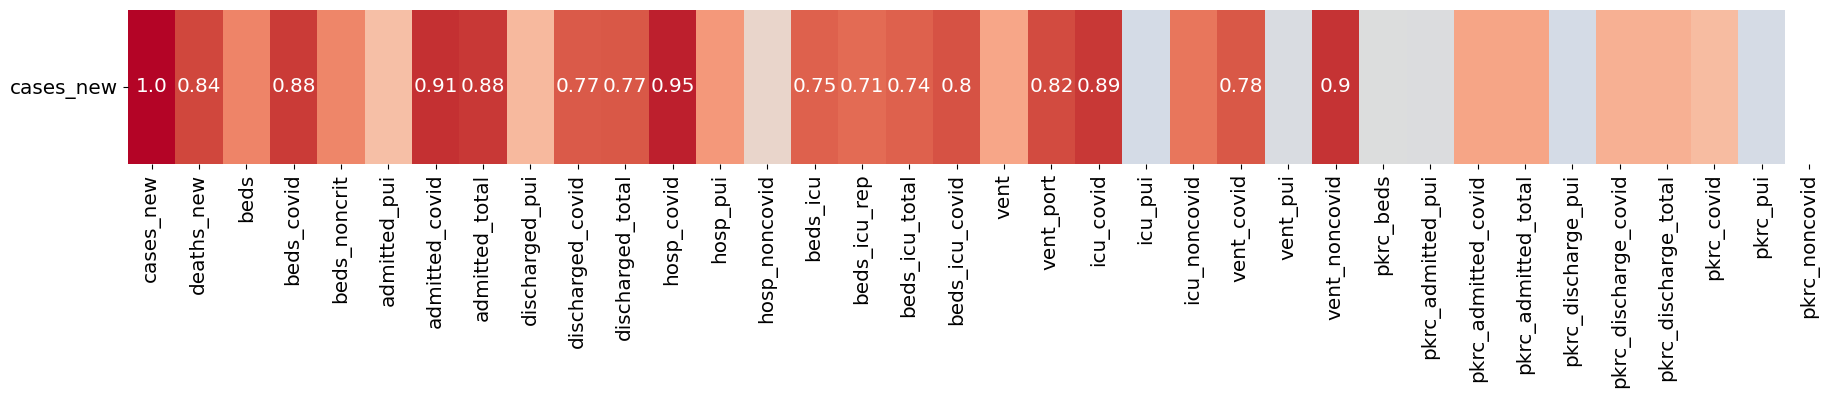

------------------------------------------------------------
Currently Showing state: Selangor


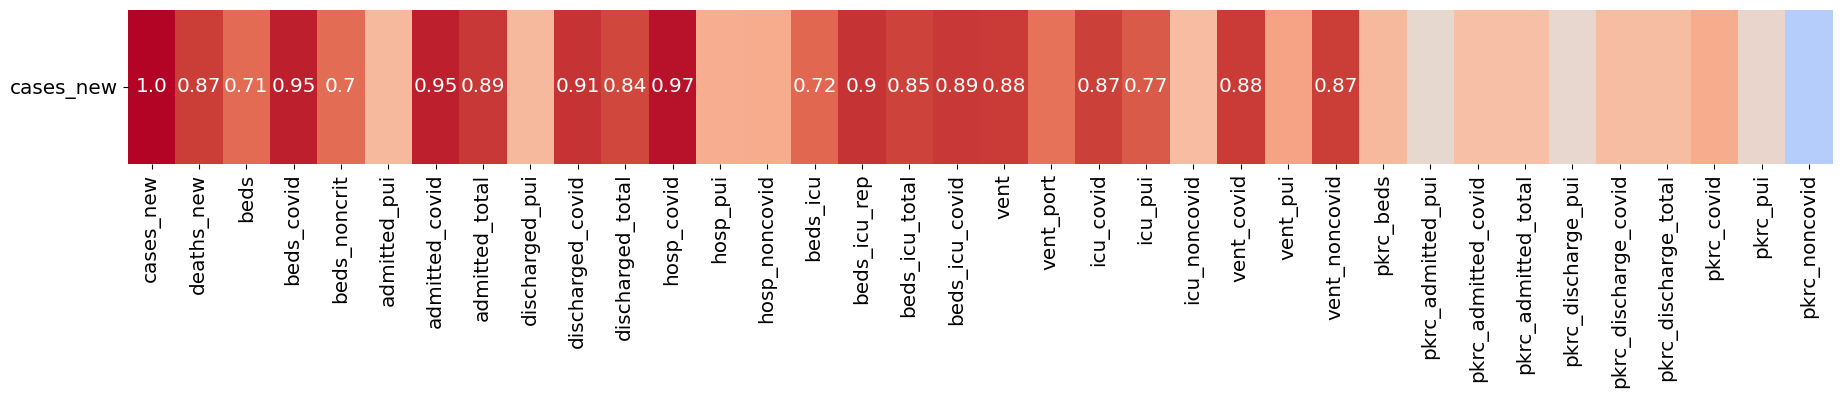

['cases_new', 'deaths_new', 'beds_covid', 'admitted_covid', 'admitted_total', 'discharged_covid', 'hosp_covid', 'vent_noncovid', 'pkrc_admitted_covid', 'pkrc_admitted_total', 'cases_new', 'admitted_covid', 'admitted_total', 'discharged_total', 'hosp_covid', 'beds_icu_rep', 'beds_icu_total', 'beds_icu_covid', 'vent_port', 'icu_covid', 'vent_covid', 'vent_noncovid', 'pkrc_beds', 'pkrc_admitted_covid', 'pkrc_admitted_total', 'pkrc_discharge_covid', 'pkrc_discharge_total', 'pkrc_covid', 'cases_new', 'deaths_new', 'beds_covid', 'admitted_covid', 'admitted_total', 'discharged_covid', 'discharged_total', 'hosp_covid', 'beds_icu_covid', 'vent_port', 'icu_covid', 'vent_covid', 'vent_noncovid', 'cases_new', 'deaths_new', 'beds_covid', 'admitted_covid', 'admitted_total', 'discharged_covid', 'discharged_total', 'hosp_covid', 'beds_icu_rep', 'beds_icu_total', 'beds_icu_covid', 'vent', 'icu_covid', 'icu_pui', 'vent_covid', 'vent_noncovid']
------------------------------------------------------------

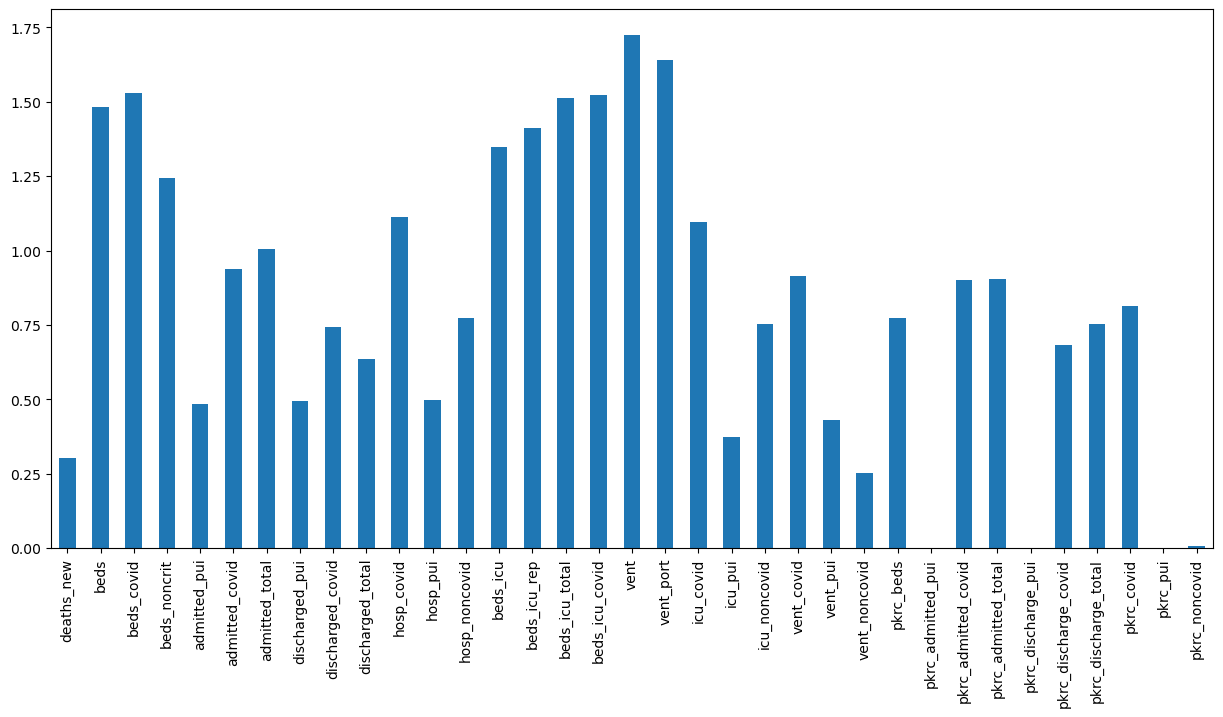

Top 10 most relevant
------------------------------------------------------------
Currently Showing state: Pahang


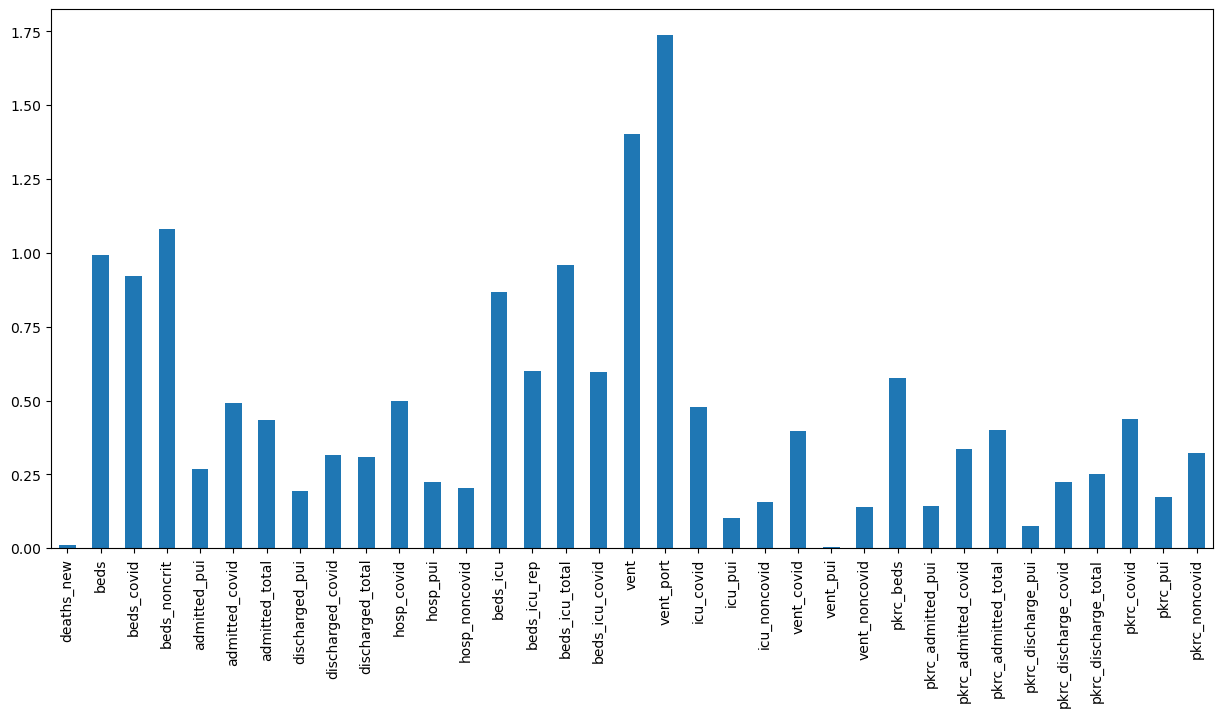

Top 10 most relevant
------------------------------------------------------------
Currently Showing state: Kedah


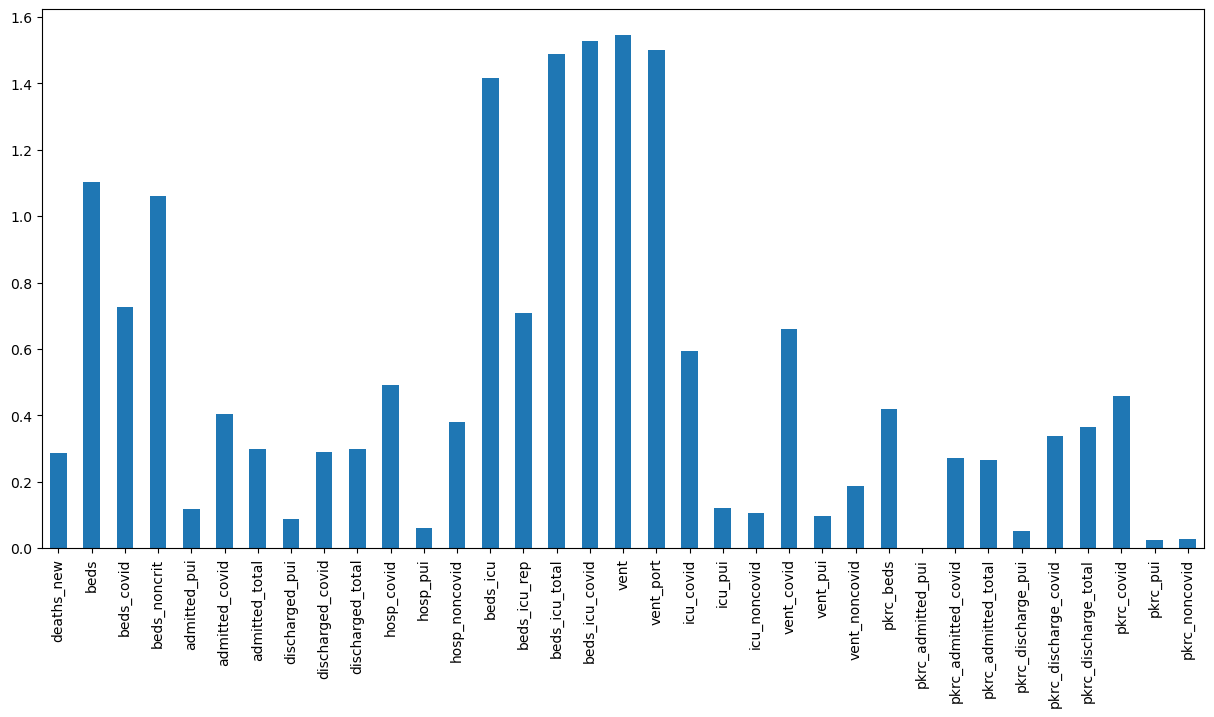

Top 10 most relevant
------------------------------------------------------------
Currently Showing state: Selangor


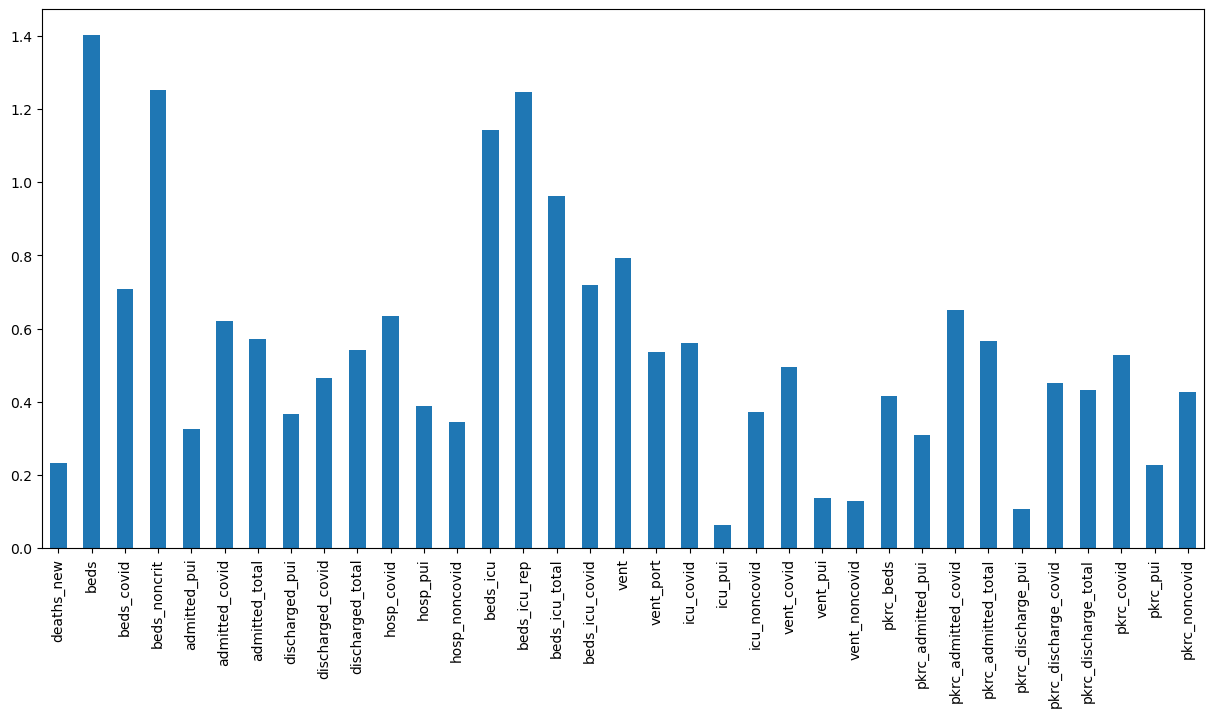

Top 10 most relevant


In [13]:
top_corr_features = []
Question3GraphType = ""
if QuestionSB == "Question 3":
    Question3GraphType = st.selectbox("Graph Type", ["Heat Map","Bar Chart"], key="Question 3 Graph Type")
    st.title(Question3GraphType + " to show Strong Features/Indicators to Daily Cases")

for corr_states in q3_state_list:
    print('-'*60)
    print('Currently Showing state: '+ corr_states)
    q3_corr_df = q3_combined_df[corr_states]
#     q3_corr_df = q3_corr_df.fillna(0)
    q3_corr_df = q3_corr_df.drop(columns=['state'])
    q3_corr_df = q3_corr_df.corr()
    q3_cases_corr_df = q3_corr_df.loc[q3_corr_df.index == 'cases_new']
    # Ploting the heatmap and shows the features that has a correlation higher than 0.7
    plt.figure(figsize=(22,2))
    ax = sns.heatmap(q3_cases_corr_df, vmin=-1, vmax=1, cbar=False,
                     cmap='coolwarm', annot=True)
    # Set the condition so that only features with 0.7 or higher correlation will show 
    for text in ax.texts:
        t = float(text.get_text())
        if -0.7 < t < 0.7:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks( size='x-large')
    plt.yticks(rotation=0, size='x-large')
    plt.show()
    if QuestionSB == "Question 3" and Question3GraphType == "Heat Map":
        st.header("Currently Showing state: " + corr_states)
        st.pyplot()
    strong_features = q3_corr_df['cases_new']
    strong_features = strong_features.loc[strong_features > 0.75]
    strong_features_list = list(strong_features.index)
    for corr_feat in strong_features_list:
        top_corr_features.append(corr_feat)
print(top_corr_features)

### For the first method, we have decided to use pearson correlation to check what features has a stronger cause and effect relationship with the daily cases for each different state individually. We then select the commonly shared features that has a correlation of above 0.7 to justify that the feature selected is universally applied to each of these states. 

### The commonlly shared features that has a correlation score higher than 0.7 is beds_icu_rep,  beds_icu_total, beds_icu_covid, icu_covid, vent_covid, vent_noncovid, admitted_covid, admitted_total, discharged_covid, discharged_total and hosp_covid. These features are the ones that will be the most helpful for training a prediction model based on pearsons correlation

In [ ]:
# 2nd Method Regression Feature Selection

# This set the number of the most relevant features
top_mutual_features = []
threshold = 10

for filter_states in q3_state_list:
    print('-'*60)
    print('Currently Showing state: '+ filter_states)
    q3_filter_df = q3_combined_df[filter_states]
    y = q3_filter_df['cases_new']
    X = q3_filter_df.drop(columns=['state', 'cases_new', 'date'])
    X = X.fillna(0)

    # Plot a barchart for easier visualization 
    feature_score = mutual_info_classif(X,y)
    feat_importances = pd.Series(feature_score, X.columns)
    plt.figure(figsize=(15, 7))
    feat_importances.plot(kind='bar')
    plt.show()
    if QuestionSB == "Question 3" and Question3GraphType == "Bar Chart":
        st.header("Currently Showing state: " + filter_states)
        st.pyplot()

    # Display the top 10 most relevant features based on mutual info classification 
    print('Top 10 most relevant')
    if QuestionSB == "Question 3" and Question3GraphType == "Bar Chart":
        st.subheader('Top 10 most relevant')
    for score, f_name in sorted(zip(feature_score, X.columns), reverse=True)[:threshold]:
        if QuestionSB == "Question 3" and Question3GraphType == "Bar Chart":
            st.markdown(f_name + ":" + str(score))
        print(f_name, score) 
        top_mutual_features.append(f_name)

### For the second method, we have chosen a module form sklearn which is the mutual info classification technique., which measure the dependency between the variables. The higher the values, the higher the dependency

### From the results, we could see many features appear as the top 10 relevant in all four states, such as vents, bed_icu etc. The appearance of these features in all 4 states top 10 relevant features might suggest that these are more universal indicators that represent strong correlation with daily cases. In other words, these features might generalize better when it is used to predict other state's daily cases.

# Question (iv) Answers

### Comparing regression and classification models, what model performs well in predicting the daily cases for Pahang, Kedah, Johor and Selangor? 
### Requirement, use two regression and classification models and use the appropriate evaluation metric

### For the data used to train the classification model for daily cases forecasting, we decide to use only the features that shows high correlation and dependancy with daily cases from question 3 above. 

### Starting off, we will extract the features of columns that shows high universal correlation and dependencies in question 3 

In [15]:
if QuestionSB == "Question 4":
    # Get the repeated features in mutual_info_class
    mutual_word_counts = collections.Counter(top_mutual_features)
    repeated_mutual_features = []

    for mutual_word, mutual_count in sorted(mutual_word_counts.items()):
        print('"%s" is repeated %d time%s.' % (mutual_word, mutual_count, "s" if mutual_count > 1 else ""))
        if mutual_count >= 3:
            repeated_mutual_features.append(mutual_word)

    print('\nMutual_info_classification features:' ,repeated_mutual_features)
    print('-'*100)

    # Get the repeated features in correlation table 
    repeated_corr_features = []
    corr_word_counts = collections.Counter(top_corr_features)

    for corr_word, corr_count in sorted(corr_word_counts.items()):
        print('"%s" is repeated %d time%s.' % (corr_word, corr_count, "s" if corr_count > 1 else ""))
        if corr_count >= 3:
            repeated_corr_features.append(corr_word)

    print("\nPearson's correlation features:" ,repeated_corr_features)
    print('-'*100)

    # Extract the features for the chosen columns later in the model training phase 
    joined_features = repeated_corr_features + repeated_mutual_features
    repeated_joined_features = []
    joined_word_counts = collections.Counter(joined_features)

    for joined_word, joined_count in sorted(joined_word_counts.items()):
        print('"%s" is repeated %d time%s.' % (joined_word, joined_count, "s" if joined_count > 1 else ""))
        if joined_count == 2:
            repeated_joined_features.append(joined_word)

    training_features = joined_features

    for repeated in repeated_joined_features:
        training_features.remove(repeated)

    print('\nFeatures that will be used in model training: ',training_features)
    print('\nTotal number of training features: ', len(training_features))



"beds" is repeated 4 times.
"beds_covid" is repeated 4 times.
"beds_icu" is repeated 4 times.
"beds_icu_covid" is repeated 4 times.
"beds_icu_rep" is repeated 4 times.
"beds_icu_total" is repeated 4 times.
"beds_noncrit" is repeated 4 times.
"hosp_covid" is repeated 2 times.
"pkrc_admitted_covid" is repeated 1 time.
"pkrc_beds" is repeated 1 time.
"vent" is repeated 4 times.
"vent_covid" is repeated 1 time.
"vent_port" is repeated 3 times.

Mutual_info_classification features: ['beds', 'beds_covid', 'beds_icu', 'beds_icu_covid', 'beds_icu_rep', 'beds_icu_total', 'beds_noncrit', 'vent', 'vent_port']
----------------------------------------------------------------------------------------------------
"admitted_covid" is repeated 4 times.
"admitted_total" is repeated 4 times.
"beds_covid" is repeated 3 times.
"beds_icu_covid" is repeated 3 times.
"beds_icu_rep" is repeated 2 times.
"beds_icu_total" is repeated 2 times.
"cases_new" is repeated 4 times.
"deaths_new" is repeated 3 times.
"dis

### In this part of the code, we will extract the X(Training Features) and y(Labels) by state

In [16]:
if QuestionSB == "Question 4":
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR

    random_seed = 9

    q4_classifier_names = ['rf_class', 'knn', 'rf_reg', 'svr']
    q4_classifiers = {}

    rf_class_clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth = 5, random_state=random_seed, n_jobs=-1)
    q4_classifiers['rf_class'] = rf_class_clf

    knn_clf = KNeighborsClassifier(n_neighbors=15, weights='uniform', n_jobs = -1)
    q4_classifiers['knn'] = knn_clf

    rf_reg_clf = RandomForestRegressor(n_estimators=1000, criterion='mae', random_state=1, n_jobs=-1)
    q4_classifiers['rf_reg'] = rf_reg_clf

    svr_clf = SVR(kernel='poly', C=0.8)
    q4_classifiers['svr'] = svr_clf

### Create a function that will plot the decision region

In [17]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=1):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.xlim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.6,
                    c=cmap(idx), edgecolor='black', marker=markers[idx], label=cl)

### After trying, we decide to leave the datasets as it is because it does not yield better results. 

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

if QuestionSB == "Question 4":
    st.title("Classification Model's MAE Score For 4 States")
    q4_state_list = ['Pahang', 'Kedah', 'Johor', 'Selangor']
    q4_combined_df = q3_combined_df
    stdsc = StandardScaler()
    mae_score_list = []
    # Set random seed so that the results is reproducable in the future
    random_seed = 9

    for q4_states in q4_state_list:
        q4_df = q4_combined_df[q4_states]
#         q4_df_std = stdsc.fit_transform(q4_df)
        y = q4_df['cases_new']
#         X = q4_df.drop(columns=['state', 'cases_new','date'])
        X = q4_df[training_features]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_seed)

        # Standardization Scaling the training features
    #     X_train_std = stdsc.fit_transform(X_train)
    #     X_test_std = stdsc.fit_transform(X_test)
    #     # Reshape 1D array into 2D array for transformation 
    #     y_train = y_train.values.reshape(len(y_train), 1)
    #     y_test = y_test.values.reshape(len(y_test), 1)
    #     y_train_std = stdsc.fit_transform(y_train)
    #     y_test_std = stdsc.fit_transform(y_test)
    #     # Reshape 2D array back into 1D array for model training 
    #     y_train = y_train.ravel()
    #     y_test = y_test.ravel()
    #     y_train_std = y_train_std.ravel()
    #     y_test_std = y_test_std.ravel()

        # Model Training 
        for classifiers in q4_classifier_names:
            print('Currently Training '+classifiers+' model for ' + q4_states)
            q4_classifiers[classifiers].fit(X_train, y_train)

            # Evaluation Metrtics 
            y_train_pred = q4_classifiers[classifiers].predict(X_train)
            y_test_pred = q4_classifiers[classifiers].predict(X_test)
            mae_score = mean_absolute_error(y_test, y_test_pred)
            mae_score_round = round(mae_score, 3)
            print('The MAE score for '+classifiers+' is ', mae_score_round)
            mae_score_list.append(mae_score_round)
            print('-'*100)

        # Plot the bar plot of the MAE scores of each model for comparison puposes
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(q4_classifier_names, mae_score_list)
        ax.set_ylabel('MAE Score')
        st.header("Performance of each model in " + q4_states)
        plt.show()
        st.pyplot()
        print('-'*100)
        mae_score_list.clear()




### For the last question which requires 2 techniques for each classification and regression models, I have used RandomForest Classification and KNearestNeighbor for classification, RandomForest Regression and SVR for regression. For the metric that is chosen to evaluate the performance of the model, I have decided to go with Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE), which is similar to MAE but gives us a more general and better feeling of how accurate is the forecast compared to the real data percentage wise.

### In this case of predicting cases, we are essentially training a model to predictict a value based on the information that we fed in. So in theory, a regression model would seem to work better for this particular situation.

### From the results, we could see that the RandomForest Regression model works best for predicting the daily cases for these states, reporting the lowest MAE and MAPE scores in all four states. We have tried standardizing the features to experiment if we could get better results. 

In [164]:
# before use streamlit:
# conda install -c conda-forge nbconvert
# run this cell
# run this cmd in anaconda powershell prompt streamlit run .\Question3.py (remember change t)
!jupyter nbconvert Question3.ipynb --to script --TagRemovePreprocessor.enabled=True --ClearMetadataPreprocessor.enabled=True -TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'

# !git clone https://github.com/heroku/python-getting-started.git
# !cd python-getting-started
# !heroku create
# git init

C:\Users\wangl\anaconda3\lib\site-packages\traitlets\traitlets.py:2196: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'remove_cell' instead of "'remove_cell'" â€“ or use CUnicode.
  warn(
[NbConvertApp] Converting notebook Question3.ipynb to script
[NbConvertApp] Writing 21100 bytes to Question3.py
'heroku' is not recognized as an internal or external command,
operable program or batch file.
